I used this tutorail https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from tensorflow import keras
from keras.models import Model, Input
from keras.layers.merge import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()
# import tensorflow_hub as hub
# from keras import backend as K
import tensorflow.keras.backend as K
# sess = tf.compat.v1.Session() 
# K.set_session(sess)

plt.style.use("ggplot")


from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/')

raw_train = np.load('/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/TRAIN_DATA_np.npy', allow_pickle=True)
raw_test = np.load('/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/TEST_DATA_np.npy', allow_pickle=True)
dataset=np.concatenate((raw_train,raw_test), axis=0)
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
print(len(raw_train),len(raw_test), len(dataset),4807 +2589)

4807 2589 7396 7396


In [4]:
sentences=[]
all_tokes=[]

for instance in raw_train:
    instance[0]=instance[0].replace("\tCopy", "")
    tokens=nltk.word_tokenize(instance[0])
    idx1=instance[1]['entities'][0][0]
    idx2=instance[1]['entities'][0][1]
    entity=instance[1]['entities'][0][2]
    sentence=[]
    for token in tokens:
        all_tokes.append(token)
        if token in instance[0][idx1:idx2].split():
            sentence.append((token,entity))
        else:
            sentence.append((token,'O'))
    sentences.append(sentence)

for instance in raw_test:
    instance[0]=instance[0].replace("\tCopy", "")
    tokens=nltk.word_tokenize(instance[0])
    idx1=instance[1][0][0]
    idx2=instance[1][0][1]
    entity=instance[1][0][2]
    sentence=[]
    for token in tokens:
        all_tokes.append(token)
        if token in instance[0][idx1:idx2].split():
            sentence.append((token,entity))
        else:
            sentence.append((token,'O'))
    sentences.append(sentence)


In [5]:
print(len(all_tokes))
# words = set(list(map(str.lower, all_tokes)))
# words.add('PADword')
# n_words = len(words)

words = list(set(all_tokes))
words.append("PADword")
n_words = len(words); n_words

print(n_words)
tags = ['O','Device','Service','Resource']
n_tags = len(tags)
print(n_tags)
print(len(sentences))

150510
13123
4
7396


In [6]:
sentences

[[('It', 'O'),
  ('lays', 'O'),
  ('a', 'O'),
  ('certain', 'O'),
  ('theoretical', 'O'),
  ('foundation', 'O'),
  ('for', 'O'),
  ('giant', 'O'),
  ('magnetostrictive', 'O'),
  ('relay', 'Device'),
  ('actuator', 'Device'),
  ('being', 'O'),
  ('used', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('fields', 'O'),
  ('of', 'O'),
  ('cutting', 'O'),
  ('with', 'O'),
  ('invariableness', 'O'),
  ('cutting', 'O'),
  ('force', 'O'),
  ('.', 'O')],
 [('He', 'O'),
  ("'s", 'O'),
  ('the', 'O'),
  ('repository', 'Resource'),
  ('of', 'O'),
  ('our', 'O'),
  ('common', 'O'),
  ('history', 'O'),
  (',', 'O'),
  ('and', 'O'),
  ('by', 'O'),
  ('that', 'O'),
  ('right', 'O'),
  (',', 'O'),
  ('grand', 'O'),
  ('patron', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('Bicentennial', 'O'),
  ('.', 'O')],
 [('Supply', 'O'),
  ('of', 'O'),
  ('ball', 'O'),
  ('valves', 'O'),
  ('of', 'O'),
  ('nominal', 'O'),
  ('diameter', 'O'),
  ('DN', 'O'),
  ('700', 'O'),
  ('full', 'O'),
  ('bore', 'O'),
  ('for', 'O'),
  (

biggest sentence has 115 words


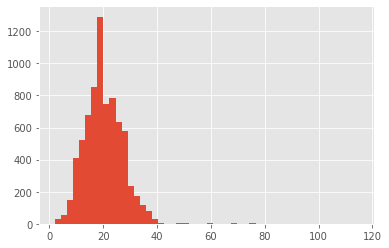

In [7]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [8]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['PADword'])
print(tags2index['O'])

max_len = 50

from keras.preprocessing.sequence import pad_sequences
X = [[words2index[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)



13122
0


In [9]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [10]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.45, random_state=2018)


In [11]:
print(len(X_tr),len(X_te),len(y_tr),len(y_te))

4067 3329 4067 3329


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


In [ ]:
pip install --user install tensorflow==1.14.0

In [ ]:
pip install --user install Keras==2.2.5

In [ ]:
pip install tensorflow keras

In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
# from tensorflow_addons.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)

model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()


In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 3660 samples, validate on 407 samples
Epoch 1/5
3660/3660 [==============================] - 11s 3ms/step - loss: 2.9132 - crf_viterbi_accuracy: 0.8839 - val_loss: 2.8099 - val_crf_viterbi_accuracy: 0.9356
Epoch 2/5
3660/3660 [==============================] - 9s 2ms/step - loss: 2.6916 - crf_viterbi_accuracy: 0.9496 - val_loss: 2.6378 - val_crf_viterbi_accuracy: 0.9609
Epoch 3/5
3660/3660 [==============================] - 9s 3ms/step - loss: 2.6009 - crf_viterbi_accuracy: 0.9732 - val_loss: 2.6108 - val_crf_viterbi_accuracy: 0.9780
Epoch 4/5
3660/3660 [==============================] - 9s 2ms/step - loss: 2.5772 - crf_viterbi_accuracy: 0.9821 - val_loss: 2.6001 - val_crf_viterbi_accuracy: 0.9829
Epoch 5/5
3660/3660 [==============================] - 9s 2ms/step - loss: 2.5646 - crf_viterbi_accuracy: 0.9856 - val_loss: 2.5923 - val_crf_viterbi_accuracy: 0.9825


In [ ]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,2.809857,0.935579,2.913243,0.883890
1,2.637806,0.960893,2.691572,0.949569
2,2.610756,0.978033,2.600878,0.973208
3,2.600112,0.982900,2.577175,0.982129
4,2.592253,0.982455,2.564602,0.985561


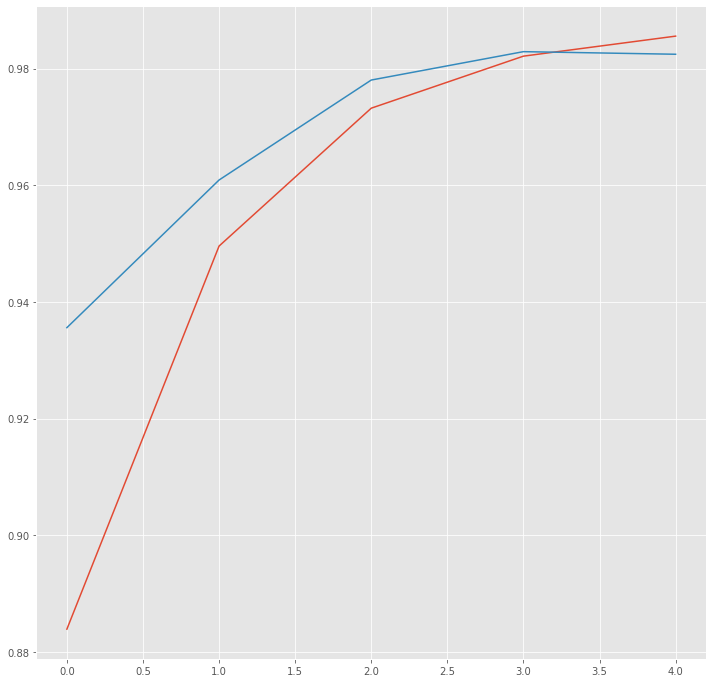

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
test_pred = model.predict(X_te, verbose=1)


3329/3329 [==============================] - 4s 1ms/step


In [ ]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Service seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Resource seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Device seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 81.6%


In [ ]:
print(classification_report(test_labels, pred_labels))


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Service seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Resource seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Device seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

      ervice       0.88      0.74      0.81       764
     esource       0.91      0.85      0.88      1738
       evice       0.67      0.81      0.74      1084

   micro avg       0.82      0.81      0.82      3586
   macro avg       0.82      0.80      0.81      3586
weighted avg       0.83      0.81      0.82      3586

